In [442]:
import os
import configparser

import numpy as np
import pandas as pd
import geopandas as gpd


import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

In [3]:
bezirke= gpd.GeoDataFrame.from_file(os.path.join(gdata_root,'Berlin', 'bezirke.gpkg'), crs ='EPSG:25833')

In [4]:
#load isochrones
slices=gpd.GeoDataFrame.from_file(os.path.join(gdata_root,'Berlin', 'water_wells_isochrones_slices.gpkg'), crs ='EPSG:4326').to_crs('EPSG:25833')

In [330]:
#load population density data
Einwohnerdichte=gpd.GeoDataFrame.from_file(os.path.join(gdata_root,'Berlin','Einwohnerdichte 2022 (Umweltatlas).gpkg'), crs ='EPSG:25833')
GHS_POP = gpd.read_parquet(os.path.join(gdata_root,'GHLS','GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R3_C20.parquet')).to_crs('EPSG:25833')

In [85]:
Einwohnerdichte.overlay(slices[slices.time==3600],how='intersection').area/Einwohnerdichte.geometry.area*Einwohnerdichte.ew2022

0           0.000000
1           0.000000
2           0.001114
3        2081.027842
4           0.000686
            ...     
26392            NaN
26393            NaN
26394            NaN
26395            NaN
26396            NaN
Length: 26397, dtype: float64

In [261]:
Einwohnerdichte.schl5=Einwohnerdichte.schl5.astype(str)
POP_Einwohnerdichte=pd.DataFrame(Einwohnerdichte.schl5)

In [ ]:
#calculate how many inhabitants belong to specific distance:
POP_Einwohnerdichte=pd.DataFrame(Einwohnerdichte.schl5)
POP_Einwohnerdichte.set_index('schl5', inplace=True)

for time in slices.time:
    tmp=slices[slices.time==time].overlay(Einwohnerdichte,how='intersection').apply(lambda row: (row.geometry.area, row.schl5), axis=1) #get overlay area and the id
    schl5=tmp.apply(lambda x: x[1])
    area=tmp.apply(lambda x: x[0])
    pops = (area/Einwohnerdichte[Einwohnerdichte.schl5.isin(schl5)].geometry.area.reset_index()[0]*Einwohnerdichte[Einwohnerdichte.schl5.isin(schl5)].reset_index().ew2022)
    dd=pd.DataFrame({'schl5':schl5,time:pops}).set_index('schl5')
    POP_Einwohnerdichte=POP_Einwohnerdichte.join(dd, on='schl5')

In [317]:
POP_Einwohnerdichte=POP_Einwohnerdichte.fillna(0)

In [ ]:
#same with GHS_POP dataset
POP_GHS = GHS_POP.reset_index().rename(columns={'index': 'idx'})

#calculate how many inhabitants belong to specific distance:

for time in slices.time:
    tmp=slices[slices.time==time].overlay(POP_GHS,how='intersection').apply(lambda row: (row.geometry.area, row.idx), axis=1) #get overlay area and the id
    index=tmp.apply(lambda x: x[1])
    area=tmp.apply(lambda x: x[0])
    pops = GHS_POP[GHS_POP.index.isin(index)].reset_index().VALUE.astype(float)*area/10012.147329
    dd=pd.DataFrame({'idx':index,time:pops}).set_index('idx')
    POP_GHS=POP_GHS.join(dd, on='idx')

In [430]:
POP_GHS=POP_GHS.fillna(0)

In [ ]:
#geodataframe->dataframe
POP_GHS=pd.DataFrame(POP_GHS.drop(columns=['VALUE','geometry'])).set_index('idx')

In [432]:
POP_Einwohnerdichte_sum=POP_Einwohnerdichte.sum()
POP_GHS_sum=POP_GHS.sum()

In [448]:
berlin_pop=pd.DataFrame([POP_Einwohnerdichte_sum,POP_GHS_sum]).T
berlin_pop.columns=['Einwohnerdichte','GHS_POP']
berlin_pop=berlin_pop.rename_axis('time').reset_index()

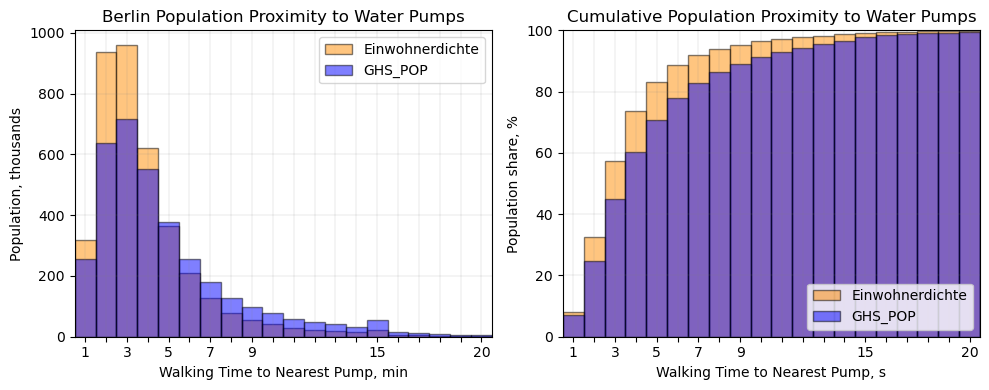

In [674]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Creates 1 row, 2 columns of subplots

axs[0].bar(berlin_pop['time'], berlin_pop['Einwohnerdichte']/1e3, width=60, color='darkorange', label='Einwohnerdichte', edgecolor='black', linewidth=1, align='center', alpha=0.5)
axs[0].bar(berlin_pop['time'], berlin_pop['GHS_POP']/1e3, width=60, color='blue', label='GHS_POP', edgecolor='black', linewidth=1, align='center', alpha=0.5)
axs[0].set_title('Berlin Population Proximity to Water Pumps')
axs[0].set_xlabel('Walking Time to Nearest Pump, min')
axs[0].set_ylabel('Population, thousands')
axs[0].legend()
axs[0].set_xlim([30,1230])
all_ticks = range(60, 1201, 60)
label_ticks = [60,180, 300, 420, 540, 900, 1200]
axs[0].set_xticks(all_ticks)
axs[0].set_xticklabels([str(int(tick/60)) if tick in label_ticks else '' for tick in all_ticks])
axs[0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


axs[1].bar(berlin_pop['time'], cumulative_einwohnerdichte, width=60, color='darkorange', label='Einwohnerdichte', edgecolor='black', linewidth=1, align='center', alpha=0.5)
axs[1].bar(berlin_pop['time'], cumulative_ghs_pop, width=60, color='blue', label='GHS_POP', edgecolor='black', linewidth=1, align='center', alpha=0.5)
axs[1].set_title('Cumulative Population Proximity to Water Pumps')
axs[1].set_xlabel('Walking Time to Nearest Pump, s')
axs[1].set_ylabel('Population share, %')
axs[1].legend(loc='lower right')
axs[1].set_xlim([30,1230])
axs[1].set_xticks(all_ticks)
axs[1].set_xticklabels([str(int(tick/60)) if tick in label_ticks else '' for tick in all_ticks])
axs[1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
axs[1].set_ylim([0,100])

plt.tight_layout()
plt.savefig('Pop_vs_proximity.png', dpi=600)

In [579]:
#did not use in the end
def gen_plots(data, extra_Label):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Creates 1 row, 2 columns of subplots

    # First Plot
    axs[0].bar(data['time'], data['Einwohnerdichte']/1e3, width=60, color='darkorange', label='Einwohnerdichte', edgecolor='black', linewidth=1, align='center', alpha=0.5)
    axs[0].bar(data['time'], data['GHS_POP']/1e3, width=60, color='blue', label='GHS_POP', edgecolor='black', linewidth=1, align='center', alpha=0.5)
    axs[0].set_title(extra_Label + ' Population Proximity to Water Pumps')
    axs[0].set_xlabel('Walking Time to Nearest Pump, min')
    axs[0].set_ylabel('Population, thousands')
    axs[0].legend()
    axs[0].set_xlim([30,1230])
    all_ticks = range(60, 1201, 60)
    label_ticks = [60,180, 300, 420, 540, 900, 1200]
    axs[0].set_xticks(all_ticks)
    axs[0].set_xticklabels([str(int(tick/60)) if tick in label_ticks else '' for tick in all_ticks])
    axs[0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    
    # Second Plot
    axs[1].bar(data['time'], cumulative_einwohnerdichte, width=60, color='darkorange', label='Einwohnerdichte', edgecolor='black', linewidth=1, align='center', alpha=0.5)
    axs[1].bar(data['time'], cumulative_ghs_pop, width=60, color='blue', label='GHS_POP', edgecolor='black', linewidth=1, align='center', alpha=0.5)
    axs[1].set_title('Cumulative Population Proximity to Water Pumps')
    axs[1].set_xlabel('Walking Time to Nearest Pump, s')
    axs[1].set_ylabel('Population share, %')
    axs[1].legend(loc='lower right')
    axs[1].set_xlim([30,1230])
    axs[1].set_xticks(all_ticks)
    axs[1].set_xticklabels([str(int(tick/60)) if tick in label_ticks else '' for tick in all_ticks])
    axs[1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    axs[1].set_ylim([0,100])
    
    plt.tight_layout()
    plt.show()

In [ ]:
tmp_1=POP_Einwohnerdichte.reset_index()
POP_Einwohnerdichte_bezirke=pd.DataFrame(POP_Einwohnerdichte_sum,columns=['Total'])
for bezirk in bezirke.namgem:
    keys=bezirke[bezirke.namgem==bezirk].overlay(Einwohnerdichte,how='intersection')['schl5']
    pd.DataFrame(tmp_1[tmp_1.schl5.isin(keys)].drop(columns='schl5').sum(), columns=[bezirk])
    POP_Einwohnerdichte_bezirke=POP_Einwohnerdichte_bezirke.join(pd.DataFrame(tmp_1[tmp_1.schl5.isin(keys)].drop(columns='schl5').sum(), columns=[bezirk]))

In [656]:
POP_Einwohnerdichte_bezirke=normalized=POP_Einwohnerdichte_bezirke.div(POP_Einwohnerdichte_bezirke.sum(axis=0), axis=1)*100
#sum percentage for time>10 min
POP_Einwohnerdichte_bezirke_10=pd.concat([POP_Einwohnerdichte_bezirke[POP_Einwohnerdichte_bezirke.index < 600], pd.DataFrame([POP_Einwohnerdichte_bezirke[POP_Einwohnerdichte_bezirke.index >= 600].sum()], index=['600+'])])

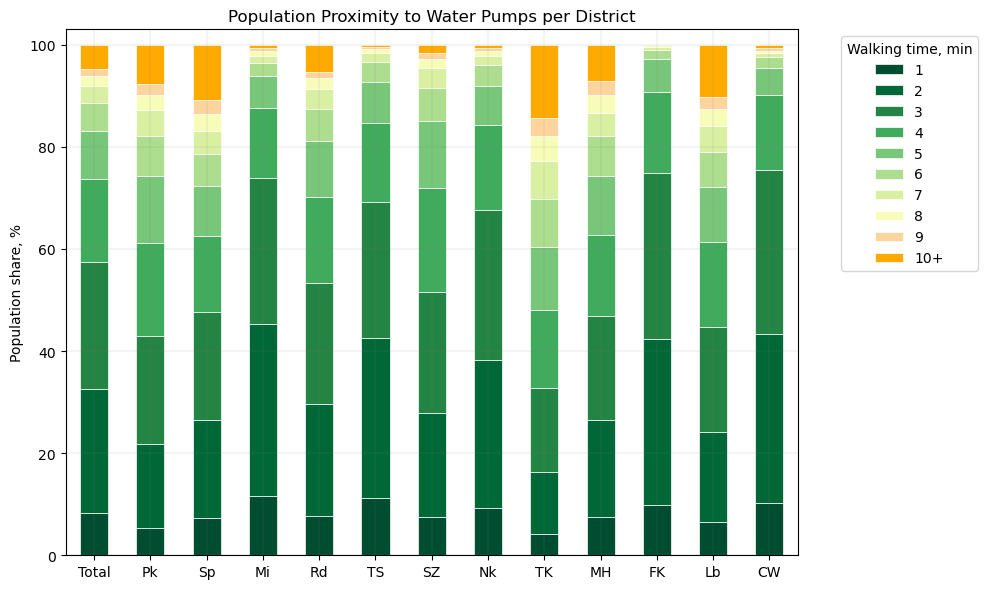

In [681]:
fig, ax = plt.subplots(figsize=(10, 6))

data_transposed = POP_Einwohnerdichte_bezirke_10.T
colors = [
    '#004D32',
    '#006837',
    '#238443',
    '#41ab5d',
    '#78c679',
    '#addd8e',
    '#d9f0a3',
    '#f7fcb9',
    '#fdd49e',  
    '#ffaa00']

data_transposed.plot(kind='bar', stacked=True, edgecolor='white', linewidth=0.5, color=colors, ax=ax)
plt.title('Population Proximity to Water Pumps per District')
plt.ylabel('Population share, %')
ax.set_ylim([0,103])
bezirk_abbreviations = {
    'Total': 'Total',
    'Pankow': 'Pk',
    'Spandau': 'Sp',
    'Mitte': 'Mi',
    'Reinickendorf': 'Rd',
    'Tempelhof-Schöneberg': 'TS',
    'Steglitz-Zehlendorf': 'SZ',
    'Neukölln': 'Nk',
    'Treptow-Köpenick': 'TK',
    'Marzahn-Hellersdorf': 'MH',
    'Friedrichshain-Kreuzberg': 'FK',
    'Lichtenberg': 'Lb',
    'Charlottenburg-Wilmersdorf': 'CW'
}

plt.xticks(ha='center')
ax.set_xticklabels([bezirk_abbreviations.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()], rotation=0, ha="center")
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
legend_labels = [str(i) for i in range(1, 11)]  # Generates labels '1' to '10'
legend_labels[-1] = '10+'  # Change the last label to '10+'
plt.legend(legend_labels, title='Walking time, min', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Pop_stacked.png', dpi=600)